## Wordle Opener Analysis from Tweets

Wordle tweet data is a useful data source and can, for example, [accurately predict](https://twitter.com/thewordlebot/status/1498661373626265600) the wordle solution for the day, as is demonstrated by other code in this repository. Analyzing the popularity of wordle openers is a little harder, since on any given day all we know are the most popular opening patterns. e.g. 🟨🟩⬜⬜⬜. I used a Ridge linear regression to look for popular openers across multiple wordles.

TDLR; the most common openers are below, though bear in mind even `adieu` is estimated to be only 1.2-5% of all openers. 

1. adieu
2. audio
3. stare
4. crane
5. irate
6. arise
7. addio [^1]
8. heart
9. great
10. arose
11. train
12. crate
13. raise
14. tears
15. roate

[^1]: A false positive due to similarity with audio.





### Load and prep the data
Most of the functionality used is in the files `first_word.py`. The function `make_first_guess_list` creates a useful dataframe for analysis.

I start with the excellent kaggle data set [wordle-tweets](https://www.kaggle.com/benhamner/wordle-tweets) and extract directly from the zipfile which I download with the [kaggle api](https://github.com/Kaggle/kaggle-api). The `get_first_words` function processes the dataframe:

    1. It removes tweeted scores that contain an invalid score line for that answer (likely played on a cached version of the puzzle, not the live one on the NY Times site).
    2. It removes any tweets that have more than 6 score patterns.
    3. It extracts the first pattern from the tweeted scores.
    4. It maps on the answer for a given wordle id.
    5. It groups by the answer for the day, and creates a dataframe that has score, target, guess, and some data on how popular that score is.

In [38]:
from first_word import make_first_guest_list
df = make_first_guest_list()

Max wordle num 292
Filtered out 18702 of 417372 rows


In [39]:
df
import plotly.io as pio
pio.renderers.default = "png"

,score,target,guess,score_frequency_rank,score_count_fraction,wordle_num,guess_count,commonality,weighted_rank
0,21000,ahead,aalii,60.0,0.001005,258,23,0,3600.0
1,21001,ahead,aargh,52.0,0.001724,258,7,71592,2704.0
2,21000,ahead,aarti,60.0,0.001005,258,23,63273,3600.0
3,20100,ahead,abaca,10.0,0.040937,258,63,79841,100.0
4,20100,ahead,abaci,10.0,0.040937,258,63,0,100.0
...,...,...,...,...,...,...,...,...,...
12940,01000,wrung,zuzim,7.0,0.050536,225,852,0,49.0
12941,00100,wrung,zygal,5.0,0.069694,225,1461,0,25.0
12942,00101,wrung,zygon,11.0,0.017046,225,153,15300,121.0
12943,00000,wrung,zymes,1.0,0.173631,225,4320,24137,1.0


### Simple analysis

We have a large dataframe of almost 600,000 columns. One row for every pattern and every guess for every wordle answer. A simple way to look at common starter words would be to group by the guess and look which words consistently rank high across several days.

In [40]:
df.groupby('guess')['score_frequency_rank'].mean().sort_values().head(10)

guess
adieu    2.512346
braze    3.259259
graze    3.345679
craze    3.555556
brave    4.506173
grate    4.586420
grave    4.592593
crave    4.802469
brane    4.856250
brace    4.938272
Name: score_frequency_rank, dtype: float64

This analysis leaves a lot to be desired. While other evidence indicates `adieu` is a popular opener, it does not seem like `jazzy` would be one. Or for that matter, words with a `z`. 

The `00000` all grey pattern is fairly common, so words with uncommon letters will show up a lot since `00000` is common because of the sheer volume of words that can create the pattern. So what happens if we  filter out the null score? Not much...

In [41]:
df.query("score != '00000'").groupby('guess')['score_frequency_rank'].mean().sort_values().head(10)

guess
adieu    2.701389
braze    3.951613
graze    4.015873
craze    4.136364
grate    5.210145
audio    5.230263
brane    5.471014
brave    5.507937
grave    5.546875
crave    5.597015
Name: score_frequency_rank, dtype: float64

So are people guessing `braze` first regularly or is something else going on? BRAZE's score line is common but what other words could make the same patern?

In [42]:
df.query('score == "00101" and wordle_num == 230').sort_values('commonality',ascending=False).head(10)

,score,target,guess,score_frequency_rank,score_count_fraction,wordle_num,guess_count,commonality,weighted_rank
5315,00101,pleat,image,9.0,0.029706,230,186,197874283,81.0
9847,00101,pleat,share,9.0,0.029706,230,186,119294241,81.0
11916,00101,pleat,until,9.0,0.029706,230,186,113090086,81.0
4576,00101,pleat,grade,9.0,0.029706,230,186,54275130,81.0
4011,00101,pleat,frame,9.0,0.029706,230,186,46079991,81.0
11974,00101,pleat,usage,9.0,0.029706,230,186,25440406,81.0
9850,00101,pleat,sharp,9.0,0.029706,230,186,24904199,81.0
4575,00101,pleat,grace,9.0,0.029706,230,186,17642126,81.0
12119,00101,pleat,villa,9.0,0.029706,230,186,17587586,81.0
10389,00101,pleat,solve,9.0,0.029706,230,186,13452150,81.0


There are a lot of words that make the same pattern, is `BRAZE` popular or is it riding the coattails of some other `_RA_E` word?

### Linear Regression

A better approach is to control for the presence of other words. If BRAZE only does well when it's paired with GRACE or GRADE or SHARE than a linear regression should isolate the guesses that actually are predictive of a popular score count line. But, there will be a lot of colinearity so we will use a Ridge regression.

The difficulty comes from getting the dataframe into the right format, thankfully I discovered [pd.crosstab](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html), and there are [other methods that were all better](https://stackoverflow.com/questions/46791626/one-hot-encoding-multi-level-column-data) than what I had been doing originally (an awful groupby loop than took over a minute.)

In [43]:
df.rename(columns={'score': 'score_pattern'}, inplace=True)

one_hot_encoded_data = pd.crosstab(
    [df['wordle_num'], df['score_pattern']], df['guess']).join(
        df.groupby(['wordle_num',
                    'score_pattern'])[['score_count_fraction',
                                       'guess_count']].first()).reset_index()


Now we'll sort of normalize the data a little and then fit a model. I will use a [Ridge](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification) which helps control the size of the coefficients, and is neccessary to handle the colinearity of the variables.

In [44]:
one_hot_encoded_data.dropna(subset=['score_count_fraction'],inplace=True) #don't need patterns no one actually guessed
# actually not sure if fillna 0 would be better?
std = one_hot_encoded_data['score_count_fraction'].std()
# mean = one_hot_encoded_data['score_count_fraction'].mean()
# one_hot_encoded_data['score_count_fraction'] = (one_hot_encoded_data[
#     'score_count_fraction'] - mean) / std

guess_count_std = one_hot_encoded_data[
    'guess_count'].std()
guess_count_mean = one_hot_encoded_data['guess_count'].mean()

one_hot_encoded_data['guess_count'] = (one_hot_encoded_data[
    'guess_count'] - guess_count_mean ) / guess_count_std

In [45]:
one_hot_encoded_data['score_count_fraction']

0        0.099927
1        0.015430
3        0.092212
4        0.002939
6        0.008082
           ...   
11481    0.000294
11482    0.000294
11483    0.000294
11486    0.005288
11488    0.000588
Name: score_count_fraction, Length: 7814, dtype: float64

In [46]:
from sklearn import linear_model
data = one_hot_encoded_data.query("wordle_num != 258") #explained further down, this data point has particularly bad colinearity issues
X= data.drop(
        columns=[ 'score_count_fraction', 'wordle_num','score_pattern']) # fit to the one hot encouded guesses and the total guess count
y=data['score_count_fraction'] # our dependent is the fraction of guesses that had the score pattern

r = linear_model.RidgeCV(alphas=[10,25,35,50])
r.fit(X,y)



RidgeCV(alphas=array([10, 25, 35, 50]))

#### Results!

Now we can just look at the coefficients of the variables to see which ones most strongly predict a popular pattern. The top few guesses contain [some](https://yougov.co.uk/topics/entertainment/articles-reports/2022/02/03/wordle-starter-words-hard-mode-and-x6-how-are-brit) [familiar](https://today.yougov.com/topics/lifestyle/articles-reports/2022/02/18/wordle-willingness-to-pay-poll) choices. 

Though to repeat, `addio` is almost certainly not real but riding the coattails of `audio`.



In [47]:
r.alpha_

25

In [48]:
top_openers = pd.DataFrame(list(zip(r.coef_, r.feature_names_in_)),
         columns=['coef', 'variable']).sort_values('coef',ascending=False)
top_openers.head(15)

,coef,variable
108,0.013261,adieu
633,0.008290,audio
10645,0.004953,stare
2362,0.004930,crane
5401,0.004632,irate
531,0.004390,arise
103,0.004288,addio
4926,0.004239,heart
4602,0.004040,great
547,0.003669,arose


Wordle 258 (solution `ahead`) is creating an issue with `adieu` - only 4 other words create the same pattern and they are riding the coattails of adieu and creeping into the top lists. The guess count is only 5, so this looks like a strong signal but it's driven by adieu, rather than the popularity of `advew`. I decided the simplest thing is to remove the 258 data point. Otherwise, all 4 of the other words show up in the top 15.




In [49]:
df.query('wordle_num == 258 and score_pattern == "21010"')

,score_pattern,target,guess,score_frequency_rank,score_count_fraction,wordle_num,guess_count,commonality,weighted_rank
102,21010,ahead,adder,3.0,0.065498,258,5,888956,9.0
108,21010,ahead,adieu,3.0,0.065498,258,5,274747,9.0
112,21010,ahead,admen,3.0,0.065498,258,5,0,9.0
130,21010,ahead,advew,3.0,0.065498,258,5,0,9.0
133,21010,ahead,adzes,3.0,0.065498,258,5,0,9.0


In [50]:
for i, var in enumerate(top_openers.query('variable != "guess_count"')['variable'].head(15)):
    print(f"{i+1}. {var}")

1. adieu
2. audio
3. stare
4. crane
5. irate
6. arise
7. addio
8. heart
9. great
10. arose
11. train
12. crate
13. raise
14. tears
15. roate


#### Just how popular is _adieu_?

Ok, so _adieu_ is popular but exactly how many people are actually using it every day? To answer this, I looked at what fraction of all tweeted score patterns are consistent with `adieu` and plot that against how many other words could have also made that pattern.

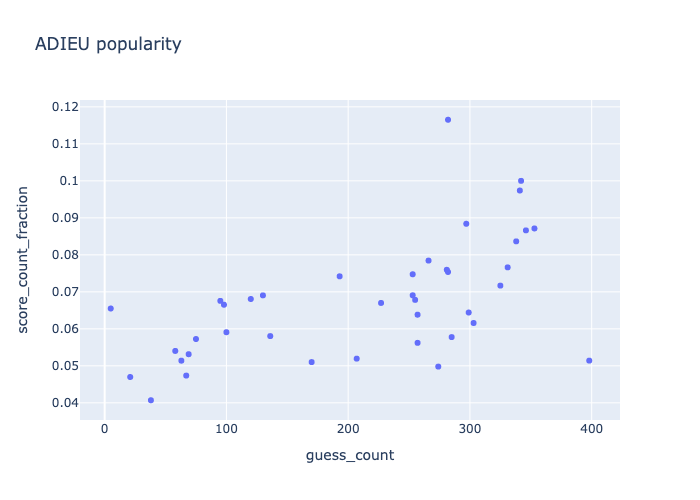

In [51]:
guess = 'adieu'
df.query(f'guess == @guess and guess_count < 400').sort_values(
    'wordle_num').plot.scatter(
        x='guess_count',
        y='score_count_fraction',
    hover_data=['score_pattern','wordle_num'],
       # color='guess_count',
        title=f'{guess.upper()} popularity',backend='plotly',
       # color_continuous_scale='bluered',
    )

So in the real data, the minimum fraction that was `adieu` was about 4%.

One could try and extrapolate the points and fit a line to this to see what it would like at a guess_count of 1 from the above data, but of course, we already fit a model to the data. The fitted Ridge model can predict what `adieu` (and all the other top choices) would do with a guess count of 1 and where `adieu` was the only word that could make it:

In [52]:

series_list = []
for word in top_openers['variable'].head(15):
    predict_dict = {word:1,'guess_count':(1 - guess_count_mean) / guess_count_std}
    series_list.append(pd.Series({x:predict_dict.get(x,int(0)) for x in X.columns}))


predict_on_this = pd.DataFrame(series_list)

top_15 = top_openers.head(15).reset_index()
top_15.loc[:,'estimated_fraction'] = r.predict(predict_on_this)
top_15

,index,coef,variable,estimated_fraction
0,108,0.013261,adieu,0.014153
1,633,0.008290,audio,0.009182
2,10645,0.004953,stare,0.005845
3,2362,0.004930,crane,0.005822
4,5401,0.004632,irate,0.005524
5,531,0.004390,arise,0.005283
6,103,0.004288,addio,0.005180
7,4926,0.004239,heart,0.005132
8,4602,0.004040,great,0.004932
9,547,0.003669,arose,0.004562


This indicates that `adieu` only represents 1.3% of starters. The infamous wordle 258 implies it's more like 6%, but we've seen it less than 6% even with more possible words. It could be that wordle 258 was something of an outlier. 

### CRANE

On February 6, 3Blue1Brown released a video positing that [CRANE was the best opener](https://www.youtube.com/watch?v=v68zYyaEmEA). Though this was later [recanted](https://www.youtube.com/watch?v=fRed0Xmc2Wg), it generated plenty of [media](https://kotaku.com/wordle-starting-word-math-science-bot-algorithm-crane-p-1848496404) [coverage](https://www.forbes.com/sites/paultassi/2022/02/08/the-best-wordle-starter-word-a-first-guess-through-science/?sh=94c150a27909). CRANE was #3 on my list overall, how does it look before and after the video?

In [34]:
data_recent = one_hot_encoded_data.query('wordle_num > 232')
X= data_recent.drop(
        columns=[ 'score_count_fraction', 'wordle_num']) # fit to the one hot encouded guesses and the total guess count
y=data_recent['score_count_fraction'] # our dependent is the fraction of guesses that had the score pattern

r = linear_model.Ridge(alpha=10)
r.fit(X,y)



Ridge(alpha=10)

In [35]:
pd.DataFrame(list(zip(r.coef_, r.feature_names_in_)),
         columns=['coef', 'variable']).sort_values('coef',ascending=False).head(5)

,coef,variable
109,0.016536,adieu
634,0.011074,audio
2363,0.007265,crane
10646,0.006171,stare
5402,0.005914,irate


CRANE is #3. What about before wordle 233?

In [36]:
data_past = one_hot_encoded_data.query('wordle_num <= 232')
X= data_past.drop(
        columns=[ 'score_count_fraction', 'wordle_num']) # fit to the one hot encouded guesses and the total guess count
y=data_past['score_count_fraction'] # our dependent is the fraction of guesses that had the score pattern

r = linear_model.Ridge(alpha=10)
r.fit(X,y)




out = pd.DataFrame(list(zip(r.coef_, r.feature_names_in_)),
         columns=['coef', 'variable']).sort_values('coef',ascending=False)
out['guess_rank'] = out['coef'].rank(ascending=False)
out.query('variable == "crane"')

Ridge(alpha=10)

,coef,variable,guess_rank
2363,0.00036,crane,1018.0


Prior to Wordle 233, CRANE ranked 1018! Quite the turnaround. (Alpha values may not be optimal for these smaller sample sizes) You can see this even in the cruder analysis, where the ranks for CRANE were much lower in the past.

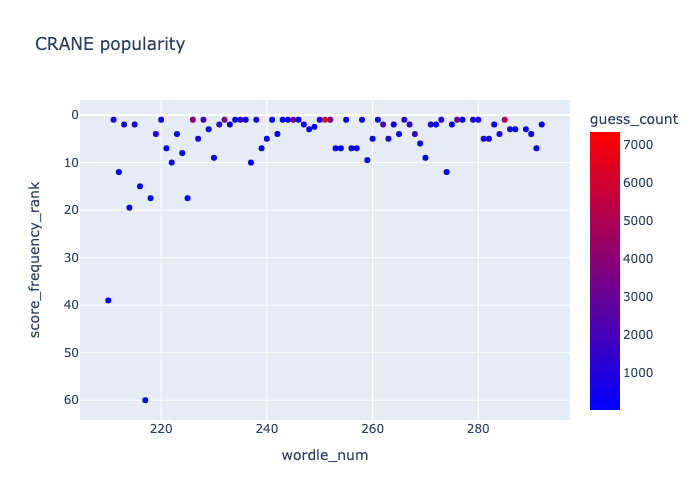

In [37]:


guess = 'crane'
myplot = df.query(f'guess == @guess').sort_values(
    'wordle_num').plot.scatter(
        x='wordle_num',
        y='score_frequency_rank',
        color='guess_count',
        title=f'{guess.upper()} popularity',backend='plotly',
        color_continuous_scale='bluered',
    )
myplot.update_yaxes(autorange="reversed")